In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
import pickle
from matplotlib import pyplot as plt
import numpy as np
from cardiac_rythm import preprocessing

Load the test data with same seed as when the model was trained.

In [23]:
from cardiac_rythm.preprocessing import load_train_test_data


x_train, x_test, y_train, y_test = load_train_test_data(
    "/home/halli/ux/BMDLab/matlab/resprog/GUI/CleanCutsDL/cutDataCinCTTI_rev_v2.mat"
)

In [24]:
directory = "../results/n_filters=5_n_fc=2/trial_084"
directory = "../../logs/results/best_04_new"
fold = 0

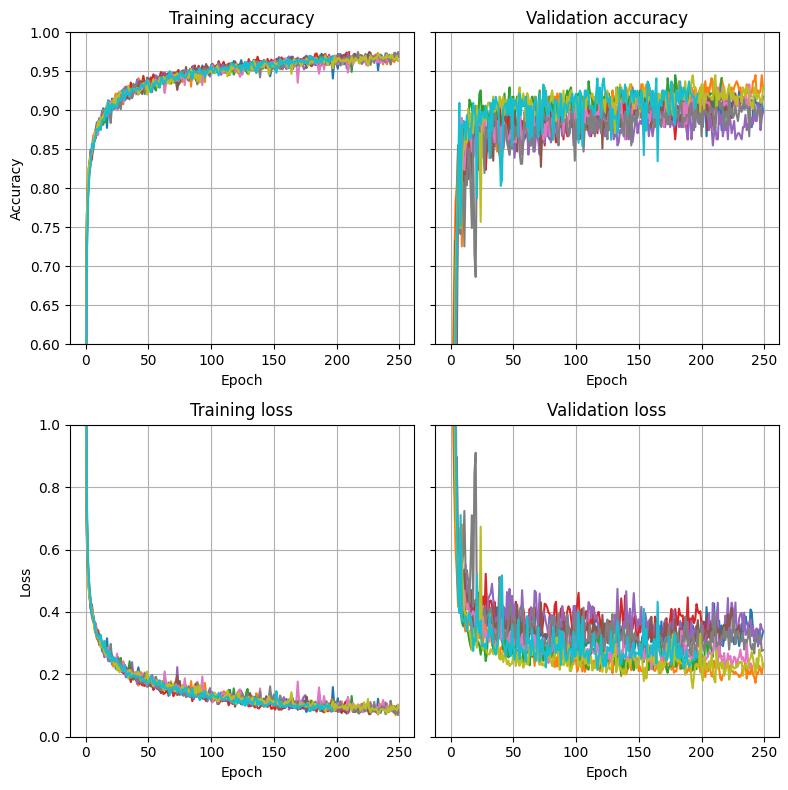

In [25]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8), sharey="row")
ax = ax.ravel()
for i in range(10):
    try:
        with open(f"{directory}/train_history_dict_{i}", "rb") as f:
            # with open(f"{directory}/history_dict_{fold}", 'rb') as f:
            history = pickle.load(f)
            ax[0].plot(history["accuracy"], label="training accuracy", alpha=1)
            ax[0].set_ylim(0.6, 1.0)
            ax[0].set_ylabel("Accuracy")
            ax[0].set_title("Training accuracy")
            ax[1].plot(history["val_accuracy"], label="validation accuracy")
            ax[1].set_title("Validation accuracy")
            ax[2].plot(history["loss"], label="training accuracy")
            ax[2].set_ylim(0.0, 1.0)
            ax[2].set_ylabel("Loss")
            ax[2].set_title("Training loss")
            ax[3].plot(history["val_loss"], label="validation accuracy")
            ax[3].set_title("Validation loss")
    except Exception as e:
        print(e)
# plt.legend(loc="upper left")
for a in ax:
    a.grid(visible=True)
    a.set_xlabel("Epoch")

fig.tight_layout()
plt.savefig("res/best_training.svg")

In [26]:
from cardiac_rythm.models import CNN, CNNConfig


saved_model = f"{directory}/checkpoint"
# saved_model = f"{directory}/checkpoint_{fold}"
predictions = []
for i in range(10):
    with open(f"{directory}/model_config.json", "rt") as f:
        model_config = CNNConfig.from_json(f.read())
    model = CNN(model_config)
    model.load_weights(f"{saved_model}_{i}").expect_partial()
    prediction = np.argmax(model.predict(x_test), axis=1)
    predictions.append(prediction)

9/9 [==============================] - 0s 5ms/step


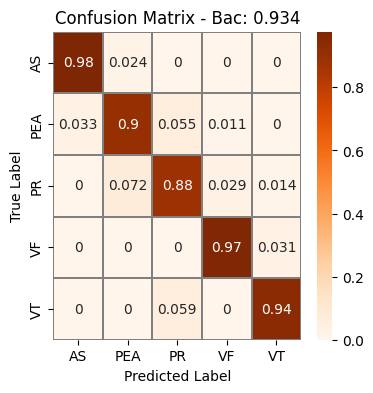

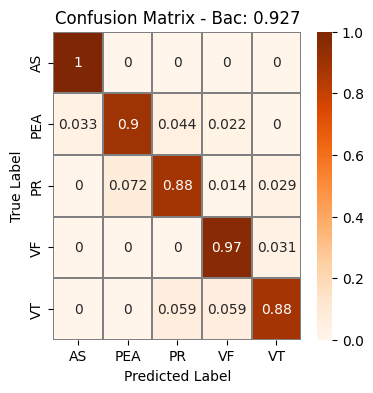

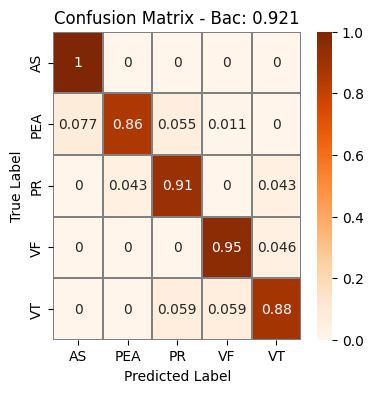

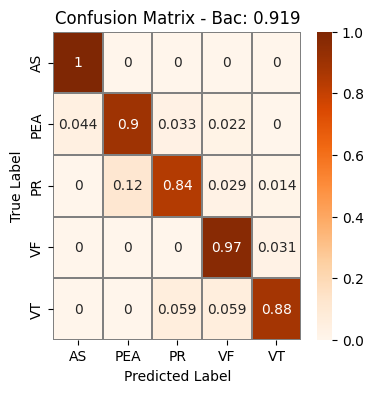

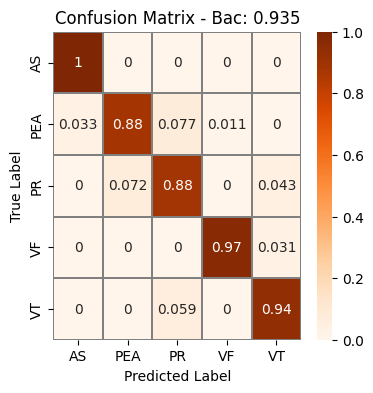

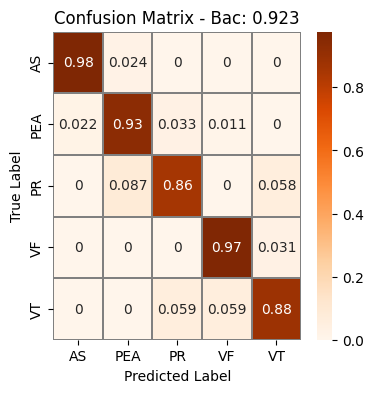

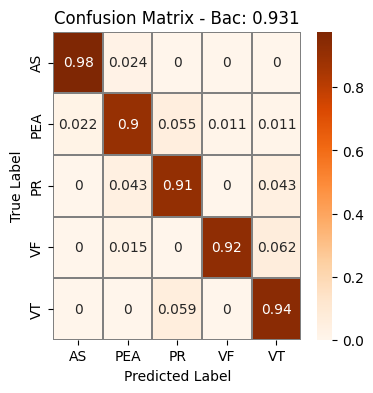

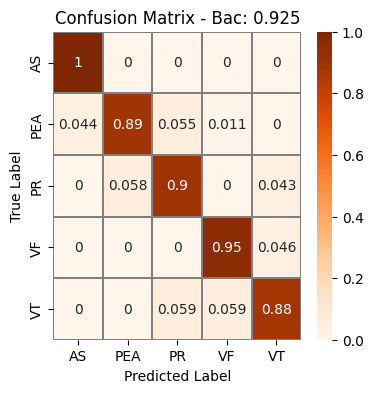

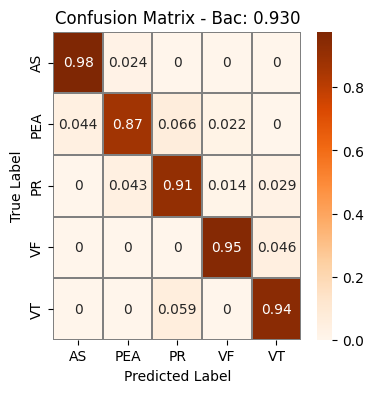

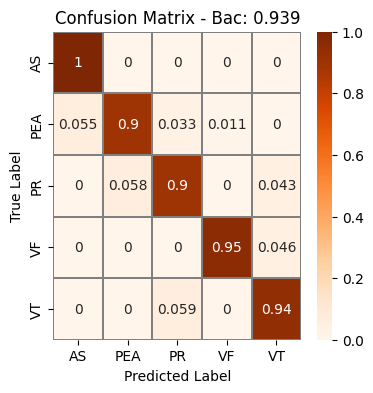

In [27]:
from sklearn.metrics import confusion_matrix, balanced_accuracy_score
import seaborn as sns

for prediction in predictions:
    conf_matrix = confusion_matrix(y_test, prediction)
    norm = conf_matrix.astype("float") / conf_matrix.sum(axis=1)[:, np.newaxis]
    bac = balanced_accuracy_score(y_test, prediction)

    f, ax = plt.subplots(figsize=(4, 4))
    sns.heatmap(norm, annot=True, linewidths=0.01, cmap="Oranges", linecolor="gray")
    ax.xaxis.set_ticklabels(["AS", "PEA", "PR", "VF", "VT"])
    ax.yaxis.set_ticklabels(["AS", "PEA", "PR", "VF", "VT"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - Bac: {bac:.3f}")
    fig.tight_layout()
    plt.show()

In [28]:
mtr = np.zeros((10, 5 * 2 + 2))


for i, prediction in enumerate(predictions):
    conf_matrix = confusion_matrix(y_test, prediction)
    bac = balanced_accuracy_score(y_test, prediction)
    acc = conf_matrix.diagonal().sum() / conf_matrix.sum()
    recall = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
    precision = conf_matrix.diagonal() / conf_matrix.sum(axis=0)
    mtr[i, :] = np.hstack((acc, bac, recall, precision))
R_mq = np.vstack((np.percentile(mtr, 50, axis=0), np.percentile(mtr, 25, axis=0), np.percentile(mtr, 75, axis=0)))
# Acc, Bac, Precision, Recall
for i, label in enumerate(["Acc", "Bac", 'AS', 'PEA', 'PR','VF', 'VT', 'AS', 'PEA', 'PR','VF', 'VT']):
    print(f"{label} {R_mq[0, i]:.2f} ({R_mq[1, i]:.2f}, {R_mq[2, i]:.2f})")

Acc 0.92 (0.92, 0.93)
Bac 0.93 (0.92, 0.93)
AS 1.00 (0.98, 1.00)
PEA 0.90 (0.88, 0.90)
PR 0.89 (0.88, 0.91)
VF 0.96 (0.95, 0.97)
VT 0.91 (0.88, 0.94)
AS 0.92 (0.91, 0.93)
PEA 0.94 (0.93, 0.95)
PR 0.91 (0.91, 0.93)
VF 0.97 (0.95, 0.98)
VT 0.74 (0.71, 0.78)


In [29]:
mtr

array([[0.92605634, 0.93435092, 0.97619048, 0.9010989 , 0.88405797,
        0.96923077, 0.94117647, 0.93181818, 0.93181818, 0.91044776,
        0.95454545, 0.84210526],
       [0.92605634, 0.92734812, 1.        , 0.9010989 , 0.88405797,
        0.96923077, 0.88235294, 0.93333333, 0.94252874, 0.92424242,
        0.94029851, 0.78947368],
       [0.91549296, 0.92127709, 1.        , 0.85714286, 0.91304348,
        0.95384615, 0.88235294, 0.85714286, 0.96296296, 0.91304348,
        0.96875   , 0.71428571],
       [0.91549296, 0.91865246, 1.        , 0.9010989 , 0.84057971,
        0.96923077, 0.88235294, 0.91304348, 0.91111111, 0.93548387,
        0.92647059, 0.83333333],
       [0.92253521, 0.93471722, 1.        , 0.87912088, 0.88405797,
        0.96923077, 0.94117647, 0.93333333, 0.94117647, 0.88405797,
        0.984375  , 0.76190476],
       [0.92605634, 0.92338252, 0.97619048, 0.93406593, 0.85507246,
        0.96923077, 0.88235294, 0.95348837, 0.92391304, 0.93650794,
        0.96923077,

In [30]:
bac

0.9389344500341943